## Data Collection

In [1]:
import requests
import pandas as pd

api_key = '62394b1cf578f2c0be0a41a79be297ee3ff9194a'   #Replace with your actual Tiingo API key
start_date = "2024-01-01"
end_date = "2024-06-14"
url = f'https://api.tiingo.com/tiingo/daily/AAPL/prices?startDate={start_date}&endDate={end_date}&token={api_key}'

response = requests.get(url)

if response.status_code == 200:
    print("Data fetched successfully")
    data = response.json()
    dataf = pd.DataFrame(data)
    dataf['date'] = pd.to_datetime(dataf['date'], errors='coerce')
    print(dataf.head())
else:
    print("Error:", response.status_code, response.text)

Data fetched successfully
                       date   close      high      low     open    volume  \
0 2024-01-02 00:00:00+00:00  185.64  188.4400  183.885  187.150  82488674   
1 2024-01-03 00:00:00+00:00  184.25  185.8800  183.430  184.220  58414460   
2 2024-01-04 00:00:00+00:00  181.91  183.0872  180.880  182.150  71983570   
3 2024-01-05 00:00:00+00:00  181.18  182.7600  180.170  181.990  62196924   
4 2024-01-08 00:00:00+00:00  185.56  185.6000  181.500  182.085  59144470   

     adjClose     adjHigh      adjLow     adjOpen  adjVolume  divCash  \
0  184.735476  187.521833  182.989027  186.238118   82488674      0.0   
1  183.352248  184.974306  182.536244  183.322394   58414460      0.0   
2  181.023650  182.195114  179.998668  181.262480   71983570      0.0   
3  180.297207  181.869508  179.292128  181.103260   62196924      0.0   
4  184.655865  184.695670  180.615648  181.197797   59144470      0.0   

   splitFactor  
0          1.0  
1          1.0  
2          1.0  
3   

## Data Loading and Preprocessing

In [2]:
#save to a csv file
import pandas_datareader as pdr
# df=pdr.get_data_tiingo('AAPL',api_key=key)
dataf.to_csv('Stock.csv')

df=pd.read_csv('Stock.csv')
df1=df.reset_index()['close']

print('df1 shape:',df1.shape)

df1 shape: (115,)


DF1 plot:


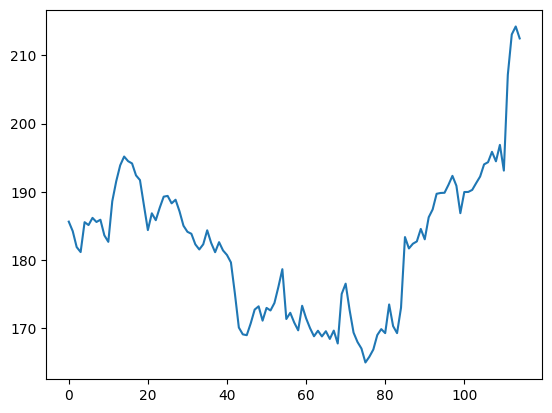

In [3]:
import matplotlib.pyplot as plt
print("DF1 plot:")
plt.plot(df1)

## Data Scaling (Normalization)

In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

print('df1 shape after min max:',df1.shape)

df1 shape after min max: (115, 1)


## Splitting Data into Training and Testing Sets

In [5]:
#65%-training  & 35%-testing
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1):1]

print("Train size:",training_size,"Test size:",test_size)

Train size: 74 Test size: 41


## Creating Input Sequences for LSTM

In [6]:
#convert array of values into dataset matrix
def create_dataset(dataset,time_step=1):
    dataX,dataY=[],[]
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX),np.array(dataY)


In [7]:
time_step=10
X_train,y_train=create_dataset(train_data,time_step)
X_test,y_test=create_dataset(test_data,time_step)

print("X_train shape:",X_train.shape,"y_train shape:",y_train.shape)
print("X_test shape:",X_test.shape,"y_test shape:",y_test.shape)


X_train shape: (63, 10) y_train shape: (63,)
X_test shape: (30, 10) y_test shape: (30,)


In [8]:
#Reshapes data into a format required for LSTM, i.e [samples,time steps,features]

X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

print("X_train shape:",X_train.shape,"y_train shape:",y_train.shape)
print("X_test shape:",X_test.shape,"y_test shape:",y_test.shape)


X_train shape: (63, 10, 1) y_train shape: (63,)
X_test shape: (30, 10, 1) y_test shape: (30,)


## Building and Training the LSTM Model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

print("Model summary:")
print(model.summary())

model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)


2025-02-09 11:53:11.183785: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-09 11:53:11.216109: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-09 11:53:11.225610: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-09 11:53:11.248779: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-09 11:53:15.136602: W tensorflow/compiler/tf2

Model summary:


2025-02-09 11:53:16.260658: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/rgukt/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.1190 - val_loss: 0.2916
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.1027 - val_loss: 0.2624
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0880 - val_loss: 0.2340
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0743 - val_loss: 0.2057
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0613 - val_loss: 0.1769
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0489 - val_loss: 0.1475
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0373 - val_loss: 0.1177
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0272 - val_loss: 0.0881
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0194 - val_loss: 0.0606
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.0156 - val_loss: 0.0381
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0171 - val_loss: 0.0245
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.02

## Making Predictions

In [10]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)  

#transback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [11]:
# calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error

print("train:",math.sqrt(mean_squared_error(y_train,train_predict)))
print("test:",math.sqrt(mean_squared_error(y_test,test_predict)))

train: 179.08165173766798
test: 182.10059359074796


## Visualizing Predictions

In [12]:
#shift train predictions for plotting
look_back=10
trainPredictPlot=np.empty_like(df1)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:]=train_predict

#shift test predictions for plotting
testPredictPlot=np.empty_like(df1)
testPredictPlot[:,:]=np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(train_predict) + (look_back * 2) + 1 + len(test_predict), :] = test_predict


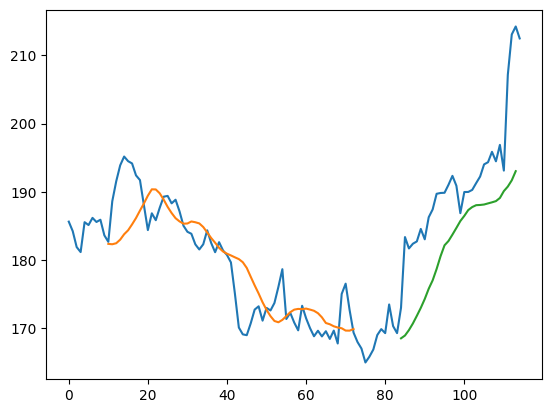

In [13]:
#Aligns train and test predictions with actual stock data
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

##  Forecasting Future Stock Prices

In [15]:
print("Test data len:",len(test_data)) #441
x_input = test_data[31:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()


Test data len: 41


In [16]:
#demonstrate prediction for next 10 days
lst_output=[]
n_steps=10
i=0
while(i<30):
    if len(temp_input)>10:
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input=x_input.reshape((1,n_steps,1))
        #print(x_input)
        yhat=model.predict(x_input,verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input=x_input.reshape((1,n_steps,1))
        yhat=model.predict(x_input,verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.6478001]
11
1 day input [0.59606011 0.62692933 0.59870024 0.64764419 0.57108042 0.85601137
 0.97623883 1.         0.96445979 0.64780009]
1 day output [[0.6864547]]
2 day input [0.62692933 0.59870024 0.64764419 0.57108042 0.85601137 0.97623883
 1.         0.96445979 0.64780009 0.68645471]
2 day output [[0.7204825]]
3 day input [0.59870024 0.64764419 0.57108042 0.85601137 0.97623883 1.
 0.96445979 0.64780009 0.68645471 0.72048253]
3 day output [[0.7456529]]
4 day input [0.64764419 0.57108042 0.85601137 0.97623883 1.         0.96445979
 0.64780009 0.68645471 0.72048253 0.74565291]
4 day output [[0.7687065]]
5 day input [0.57108042 0.85601137 0.97623883 1.         0.96445979 0.64780009
 0.68645471 0.72048253 0.74565291 0.7687065 ]
5 day output [[0.7815352]]
6 day input [0.85601137 0.97623883 1.         0.96445979 0.64780009 0.68645471
 0.72048253 0.74565291 0.7687065  0.78153521]
6 day output [[0.7996398]]
7 day input [0.97623883 1.         0.96445979 0.64780009 0.68645471 0.72048253
 0

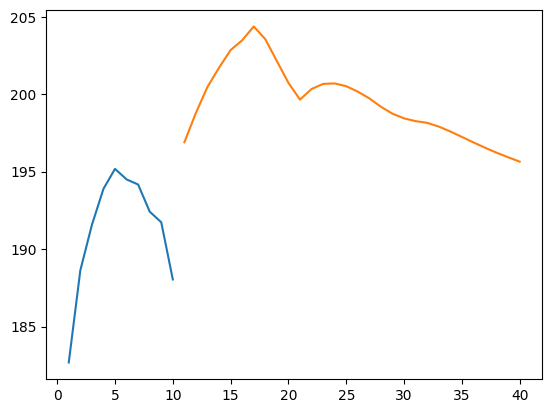

In [17]:
day_new=np.arange(1,11)
day_pred=np.arange(11,11 + len(lst_output))

df3=df1.tolist()
df3.extend(lst_output)

plt.plot(day_new,scaler.inverse_transform(df1[10:20]),label="Actual Data")
plt.plot(day_pred,scaler.inverse_transform(lst_output),label="Predicted Data")
